<span style="font-size: 250%;color:#1155cc"> IC_SEC Sieć neuronowa

<span style="font-size: 150%;color:Red"> 17.07.2021

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio
import pandas as pd


In [2]:
df = pd.read_excel('/media/wojciech/D6DE33C1DE339927/1A/dane1.xlsx')    
print(df.dtypes)
df.head(4)

Timestamp    datetime64[ns]
Value                 int64
dtype: object


,Timestamp,Value
0,2020-05-01 00:00:00.000,0
1,2020-05-01 00:00:10.000,10
2,2020-05-01 00:00:20.000,20
3,2020-05-01 00:00:29.985,30


In [3]:
df = df.reset_index()

In [4]:
df['hour']= df['Timestamp'].dt.hour.astype(np.float32)
df['minute']= df['Timestamp'].dt.minute.astype(np.float32)
df['second']= df['Timestamp'].dt.second.astype(np.float32)
df.head(3)

,index,Timestamp,Value,hour,minute,second
0,0,2020-05-01 00:00:00,0,0.0,0.0,0.0
1,1,2020-05-01 00:00:10,10,0.0,0.0,10.0
2,2,2020-05-01 00:00:20,20,0.0,0.0,20.0


In [5]:
df.columns = ['Count', 'Timestamp', 'Value', 'hour', 'minute', 'second']
df.tail(3)

,Count,Timestamp,Value,hour,minute,second
498,498,2020-05-01 01:22:57.510,20,1.0,22.0,57.0
499,499,2020-05-01 01:23:07.505,10,1.0,23.0,7.0
500,500,2020-05-01 01:23:17.500,0,1.0,23.0,17.0


In [6]:
df['Count']=df['Count'].astype(np.float32)
df['Value']=df['Value'].astype(np.float32)

### Krok 1. Tworzenie zbioru danych 

In [7]:
#torch.manual_seed(1)    # reproducible

x = df['second']
y = df['Value']              

x = torch.tensor(x) 
y = torch.tensor(y)        


# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)


In [8]:
df['Count']

0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
       ...  
496    496.0
497    497.0
498    498.0
499    499.0
500    500.0
Name: Count, Length: 501, dtype: float32

In [9]:
df['Value'].value_counts()

90.0     50
80.0     50
70.0     50
60.0     50
50.0     50
40.0     50
30.0     50
20.0     50
10.0     50
0.0      26
100.0    25
Name: Value, dtype: int64

### Krok 2. Definiowanie sieci neuronowej
##### 2.1 Programowanie torch.nn.Module

##### 2.2 Definicja krztałtu sieci
Ta sieć ma tylko jedną ukrytą warstwę, ale teraz ma 150 węzłów, a po nim następuje funkcja LeakyReLu.
Musi byc jedna zmienna wejściowa i jedna wartość wynikowa żeby były takie fajne wykresy dwówymiarowe

In [10]:
y = y.view([501,1])
x = x.view([501,1])

N, D_in = x.shape
N, D_out = y.shape

H = 500                            ## the number of dimensions of the inner layer
device = torch.device('cpu')

In [11]:
net = torch.nn.Sequential(
        torch.nn.Linear(D_in,  H),   # INPUT layer
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, H),        # inner layer
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, D_out),    # output layer
    ).to(device)  

##### 2.2 Algorytm optymalizacji: 

##### Optymalizator SGD
lr: Szybkość uczenia się -> Szybkość, z jaką nasz model aktualizuje wagi w komórkach za każdym razem, gdy przeprowadzana jest wsteczna propagacja

In [12]:
#optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

##### Optymalizator ADAM 
zamiast użytego optymalizatora SGD, działa lepiej dla powykręcanego zbioru danych empirycznych. Należy przetestować różne rodzaje optymalizatorów.

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

##### Optymalizator ADAMMAX

In [14]:
#optimizer = torch.optim.Adamax(net.parameters(), lr=0.01)

##### Optymalizator ASGD

In [15]:
#optimizer = torch.optim.ASGD(net.parameters(), lr=0.01, lambd=0.0001, alpha=0.15, t0=000000.0)

In [16]:
#optimizer = torch.optim.LBFGS(net.parameters(), lr=0.01, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)

Bardzo dobre efekty daje optimizer RMSprop

In [17]:
#optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08)

Doskonałę efekty daje optimizer RMSprop

In [18]:
#optimizer = torch.optim.Rprop(net.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

In [19]:
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False)

##### 2.2 Definicja funkcji straty
to jest R2 dla regresji

In [20]:
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [21]:
print(y[:2])
print(x[:2])

tensor([[ 0.],
        [10.]])
tensor([[ 0.],
        [10.]])


### Krok 3. Definiowanie procesu nauki i nauka

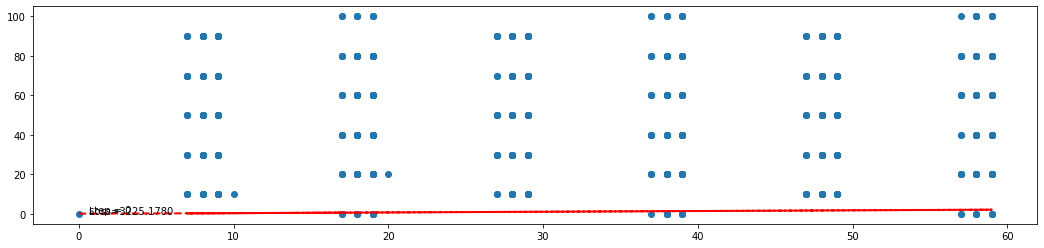

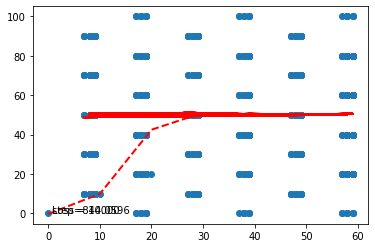

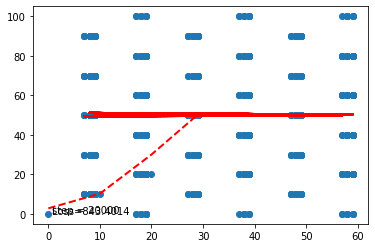

KeyboardInterrupt: 

In [22]:
plt.figure(figsize=(18,4))
inputs = Variable(x)                         #1. deklarujemy x i y do nauki
outputs = Variable(y)
for i in range(200000):                          #2. pętla 20 000 powtórzeń (epok)
   prediction = net(inputs)
   loss = loss_func(prediction, outputs) 
   optimizer.zero_grad()
   loss.backward()        
   optimizer.step()       
                        # nie mogę użyć CUDA bo nie zadziała wykres numpy!!!
                        # obliczenia trwają kilka razy dłużej

   if i % 10000 == 0:                             #3. Pokazuje naukę co 10 000 kroków
       
       plt.cla()
       plt.scatter(x.data.numpy(), y.data.numpy())
       plt.plot(x.data.numpy(), prediction.data.numpy(), 'r--', lw=2)
       plt.text(0.65, 0.1, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'black'})
       plt.text(0.65, 0.3, 'step = %d' % i, fontdict={'size': 10, 'color':  'black'})
       plt.pause(0.1)

plt.show()

<span style="font-size: 160%;color:#0c343d;background:#fff2cc"> We save the whole model

In [ ]:
torch.save(net,'/home/wojciech/Pulpit/7/IC15.pb')

<span style="font-size: 160%;color:#0c343d;background:#fff2cc"> We play the whole model
    
    The model is now not called 'net' but 'KOT'

In [ ]:
KOT = torch.load('/home/wojciech/Pulpit/7/IC15.pb')
KOT

In [ ]:
with torch.no_grad():
    y_interp = KOT(Xtest)  
    loss = (y_interp - ytest).pow(2).mean()

    print(f'Loss train_set: {loss:.8f}')

In [ ]:
y_interp

# 